In [4]:

# %% Imports

from ast import arg
from pytorch_lightning.loggers import WandbLogger

import time

from model import deep_GNN
import torch
from torch import device, nn
import torch
import os
from utils.dataset import H5GeometricDataset
from utils.eval import evaluate
from utils.train import train_one_epoch
from utils.configs.config import *
import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from model import LitModel
import numpy as np
from torch.utils.data import ConcatDataset
from pytorch_lightning.callbacks import ModelCheckpoint

from utils.configs.config_dict import get_config





Number of CPUs: 14
Memory CPU in GB: 36.0


In [5]:
# DATA LOADING
TIME_MEANS = np.load(TIME_MEANS_PATH)[0, :N_VAR]
MEANS = np.load(GLOBAL_MEANS_PATH)[0, :N_VAR]
STDS = np.load(GLOBAL_STDS_PATH)[0, :N_VAR]
M = torch.as_tensor((TIME_MEANS - MEANS)/STDS)[:, 0:HEIGHT].unsqueeze(0)
STD = torch.tensor(STDS).unsqueeze(0)
datasets = {
    "train": ConcatDataset([H5GeometricDataset(os.path.join(DATA_FILE_PATH, f"{year}.h5"), means=MEANS, stds=STDS) for year in YEARS]),
    "val": H5GeometricDataset(VAL_FILE, means=MEANS, stds=STDS)
}



In [6]:
from utils.configs.config import BATCH_SIZE, BATCH_SIZE_VAL, LEARNING_RATE, MODEL_CONFIG
from utils.eval import weighted_rmse_channels
from torch.optim import Adam
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from torch.utils.data import DistributedSampler
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader


class GraphCON(nn.Module):
    def __init__(self, GNNs, dt=1., alpha=1., gamma=1., dropout=None):
        super(GraphCON, self).__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.GNNs = GNNs  # list of the individual GNN layers
        self.dropout = dropout

    def forward(self, X0, Y0, edge_index):
        # set initial values of ODEs

        # solve ODEs using simple IMEX scheme
        for gnn in self.GNNs:
            Y0 = Y0 + self.dt * (torch.relu(gnn(X0, edge_index)) -
                                 self.alpha * Y0 - self.gamma * X0)
            X0 = X0 + self.dt * Y0

            if (self.dropout is not None):
                Y0 = F.dropout(Y0, self.dropout, training=self.training)
                X0 = F.dropout(X0, self.dropout, training=self.training)

        return X0, Y0


class deep_GNN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, nlayers, dt=1., alpha=1., gamma=1., dropout=None):
        super(deep_GNN, self).__init__()
        self.enc = nn.Linear(nfeat, nhid)
        self.GNNs = nn.ModuleList()
        for _ in range(nlayers):
            self.GNNs.append(GCNConv(nhid, nhid))
        self.graphcon = GraphCON(self.GNNs, dt, alpha, gamma, dropout)
        self.dec = nn.Linear(nhid, nclass)

    def forward(self, x0, edge_index):
        # compute initial values of ODEs (encode input)
        x0 = self.enc(x0)
        # stack GNNs using GraphCON
        x0, _ = self.graphcon(x0, x0, edge_index)
        # decode X state of GraphCON at final time for output nodes
        x0 = self.dec(x0)
        return x0

In [7]:

gnn_model = deep_GNN(**MODEL_CONFIG)
model = LitModel(datasets=datasets, std=STD, model= gnn_model)

In [9]:
dataloaders = model.train_dataloader()

# %% Training
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")

    for i, batch in enumerate(dataloaders):
        loss = model.training_step(batch, 0)
        # backwad pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch} --- Batch: {i} --- Loss: {loss.item():.2f}")
        if i == 5:
            break


    

Epoch 0
Number of CPUs: 14
Memory CPU in GB: 36.0


/Users/magnus/Documents/eth/PMLR/venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Epoch: 0 --- Batch: 0 --- Loss: 673.92
Epoch: 0 --- Batch: 1 --- Loss: 671.24
Epoch: 0 --- Batch: 2 --- Loss: 665.12
Epoch: 0 --- Batch: 3 --- Loss: 652.81
Epoch: 0 --- Batch: 4 --- Loss: 645.10
Epoch: 0 --- Batch: 5 --- Loss: 644.06
Epoch 1
Epoch: 1 --- Batch: 0 --- Loss: 638.47
Epoch: 1 --- Batch: 1 --- Loss: 634.36
Epoch: 1 --- Batch: 2 --- Loss: 628.92
Epoch: 1 --- Batch: 3 --- Loss: 621.71
Epoch: 1 --- Batch: 4 --- Loss: 615.68
Epoch: 1 --- Batch: 5 --- Loss: 614.80
Epoch 2
Epoch: 2 --- Batch: 0 --- Loss: 609.01
Epoch: 2 --- Batch: 1 --- Loss: 607.43
Epoch: 2 --- Batch: 2 --- Loss: 601.76
Epoch: 2 --- Batch: 3 --- Loss: 595.44
Epoch: 2 --- Batch: 4 --- Loss: 590.16
Epoch: 2 --- Batch: 5 --- Loss: 589.69
Epoch 3
Epoch: 3 --- Batch: 0 --- Loss: 584.61
Epoch: 3 --- Batch: 1 --- Loss: 583.01
Epoch: 3 --- Batch: 2 --- Loss: 578.20
Epoch: 3 --- Batch: 3 --- Loss: 572.79
Epoch: 3 --- Batch: 4 --- Loss: 568.00
Epoch: 3 --- Batch: 5 --- Loss: 568.81
Epoch 4
Epoch: 4 --- Batch: 0 --- Loss: 

In [11]:
# plot output predictions

# save stupid model
path = os.path.join("models", "small_model.pth")
# create
if not os.path.exists("models"):
    os.makedirs("models")
torch.save(model.state_dict(), path)
print(f"Model saved at {path}")

Model saved at models/small_model.pth


In [76]:
# load model
model.load_state_dict(torch.load(path))
model.eval()
for i, batch in enumerate(dataloaders):
    x, edge_index, target = batch
    y_hat = model(x, edge_index)
    rmse = weighted_rmse_channels(y_hat, target)
    rmse_scaled = rmse * STD.squeeze()
    break
    
# print(y_hat)
# print(target)
# print(rmse)

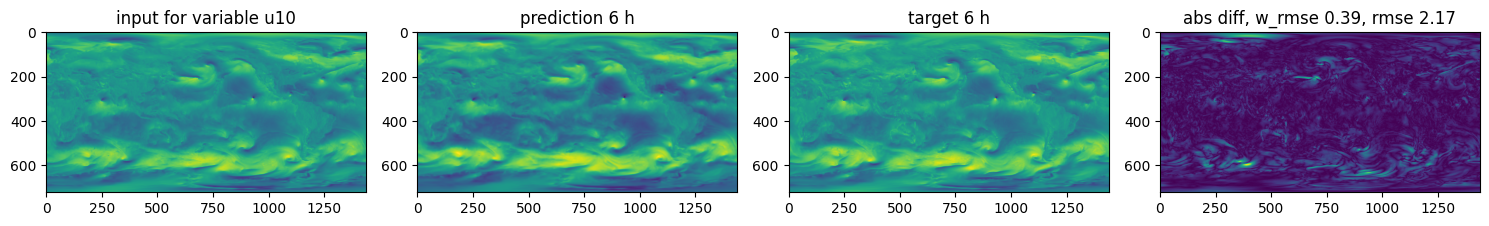

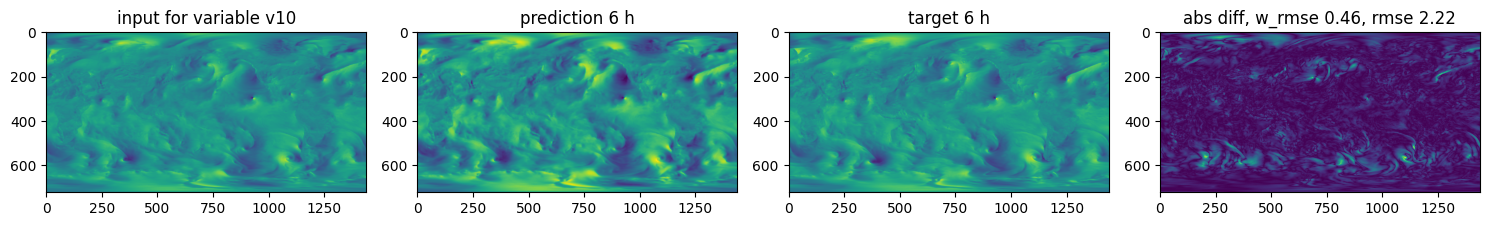

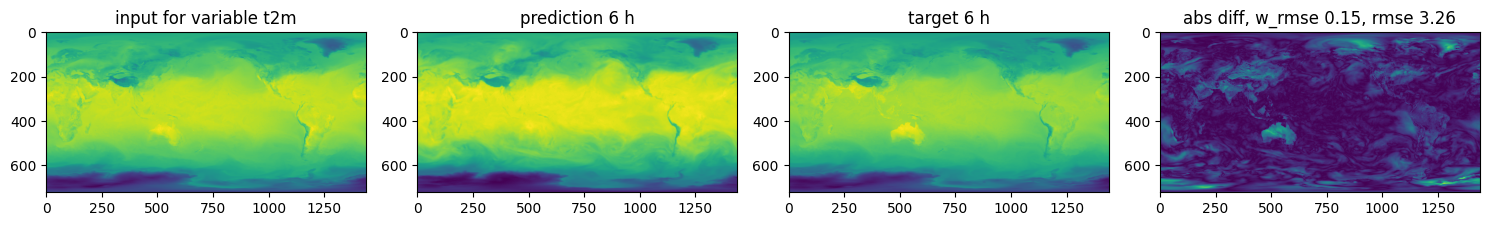

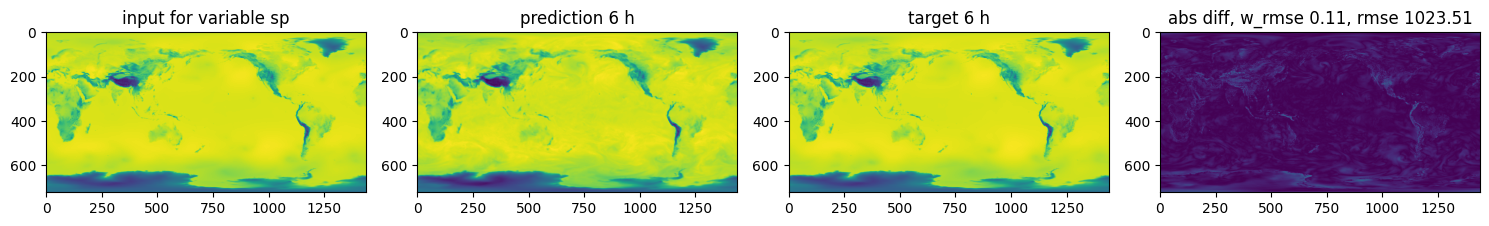

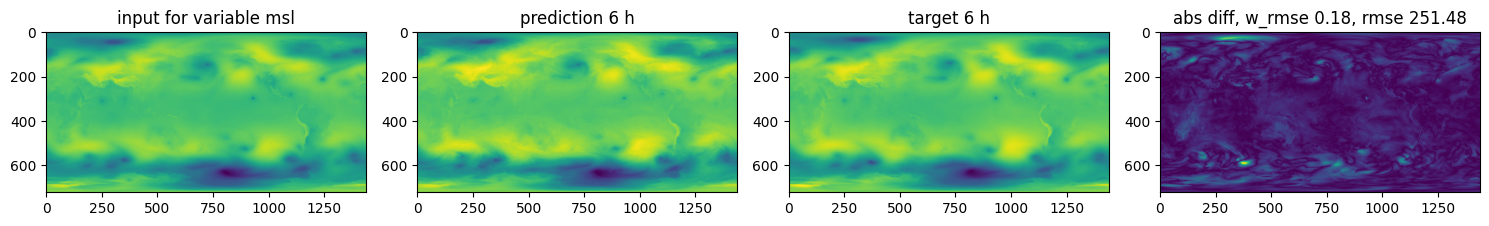

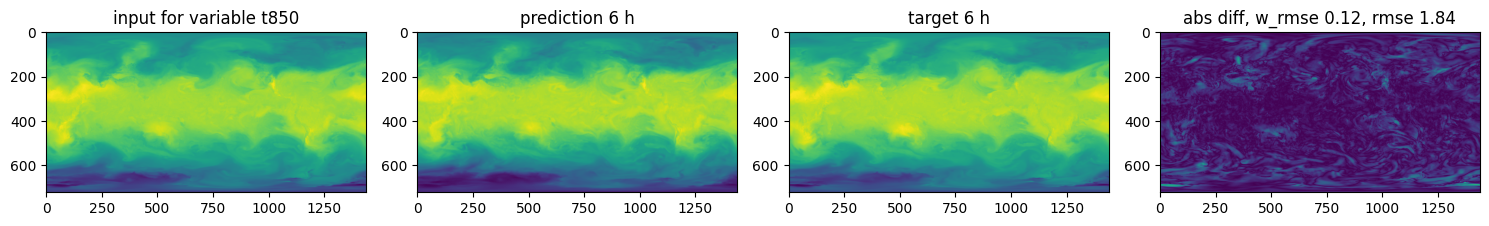

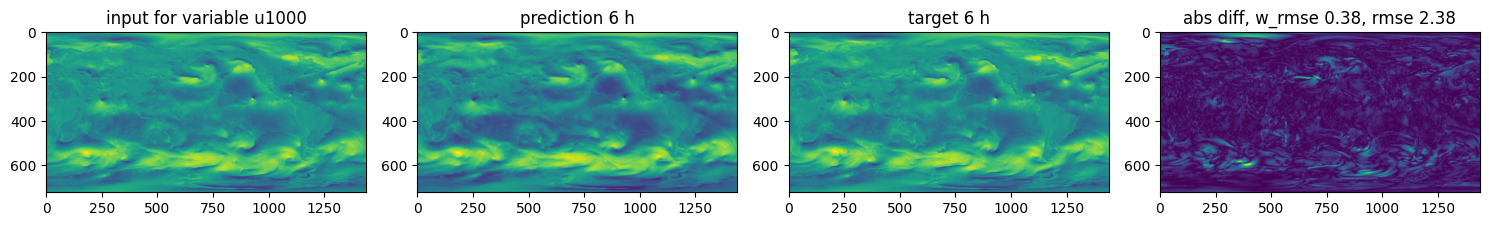

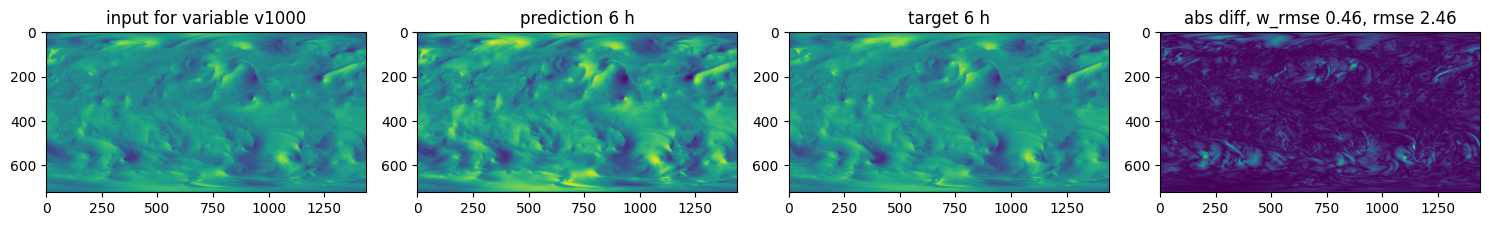

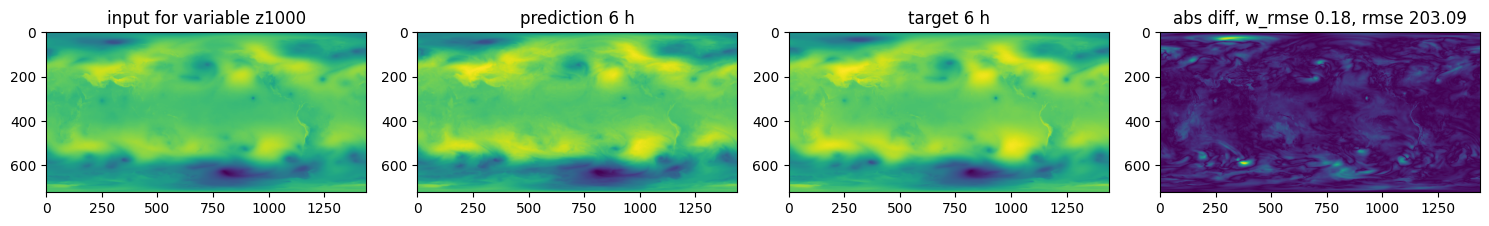

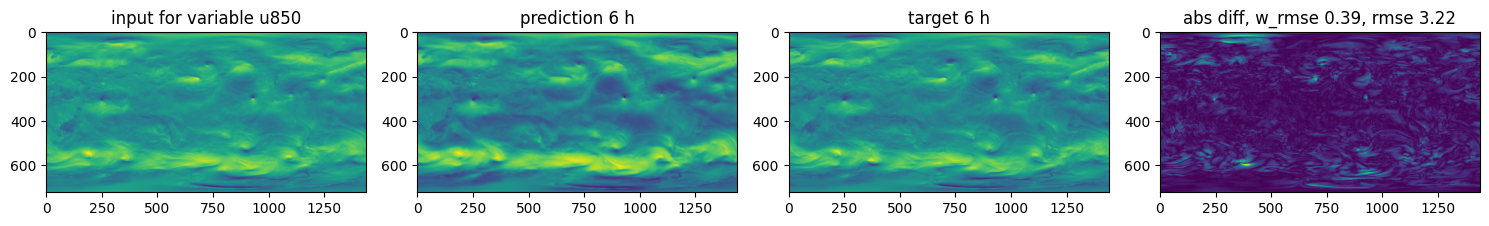

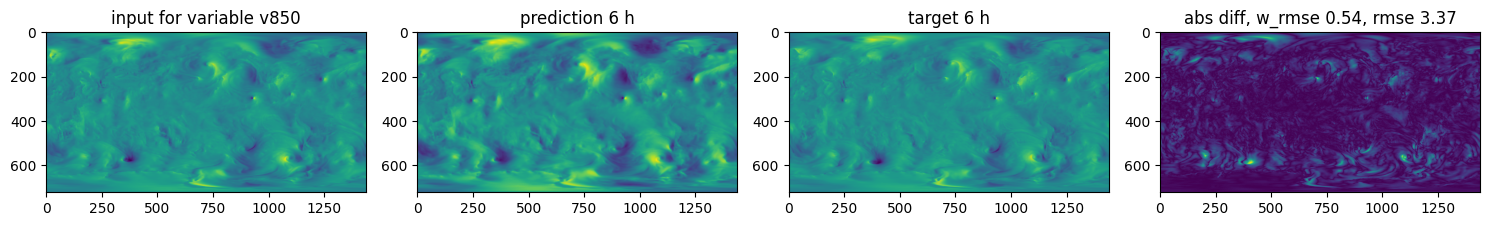

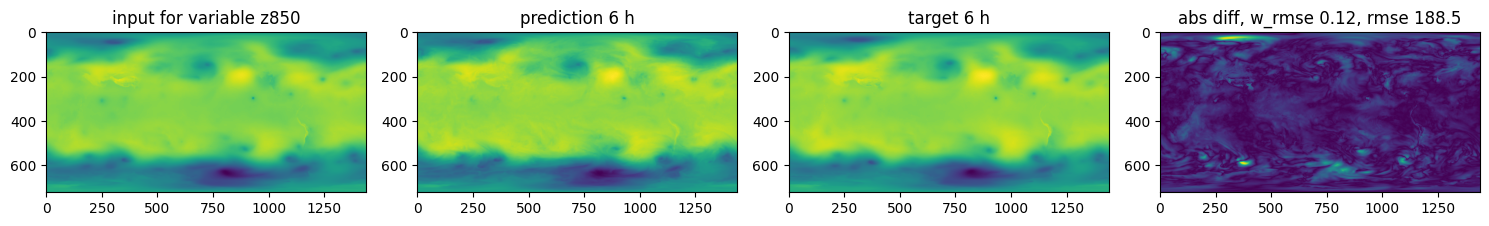

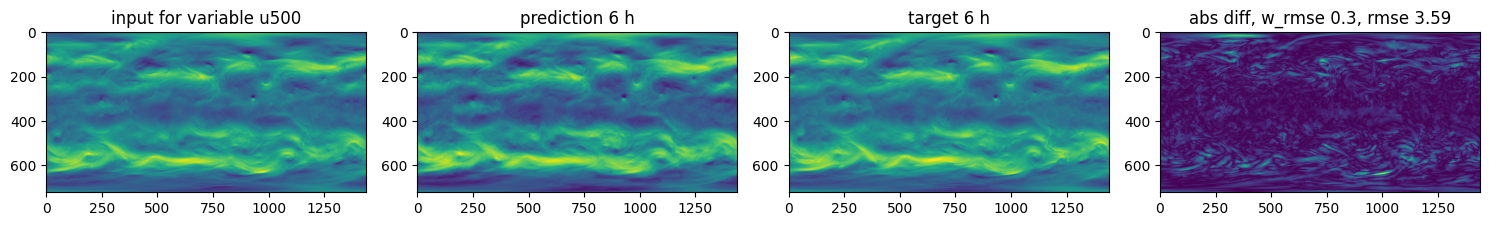

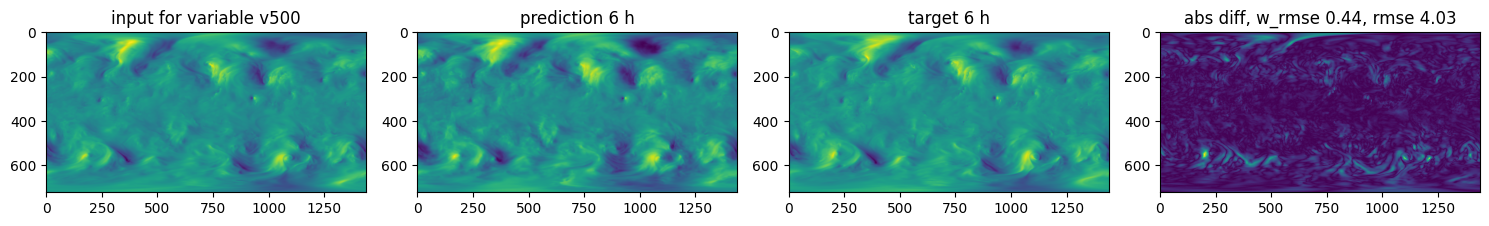

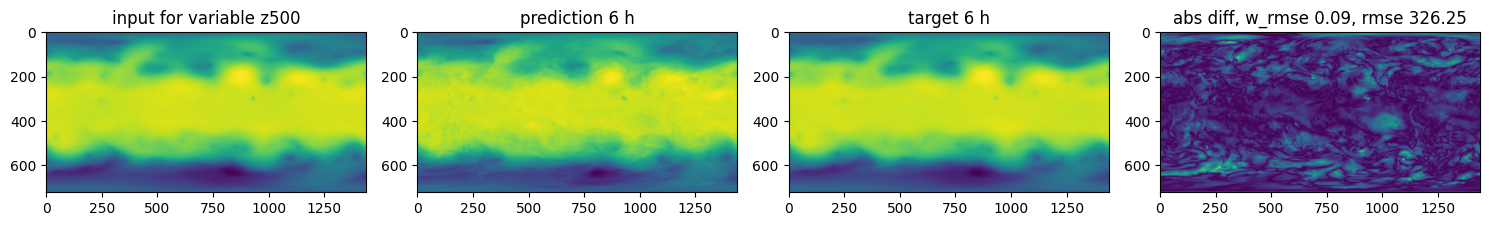

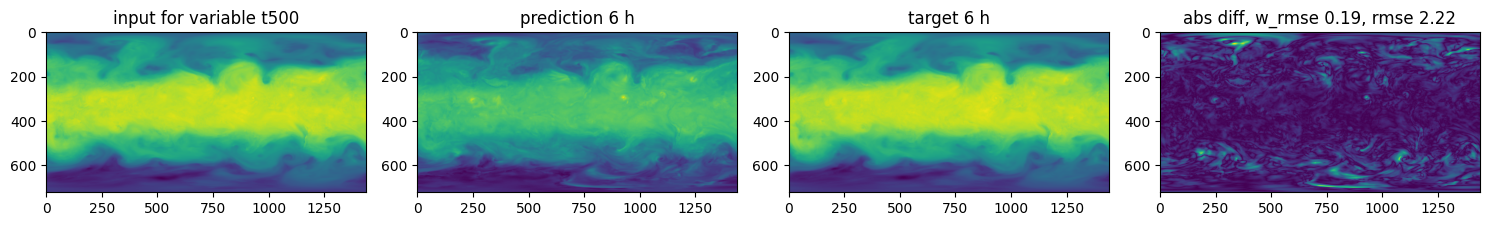

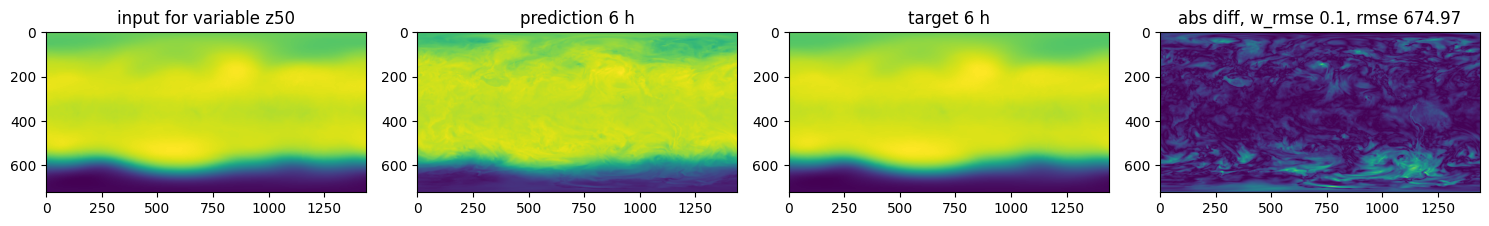

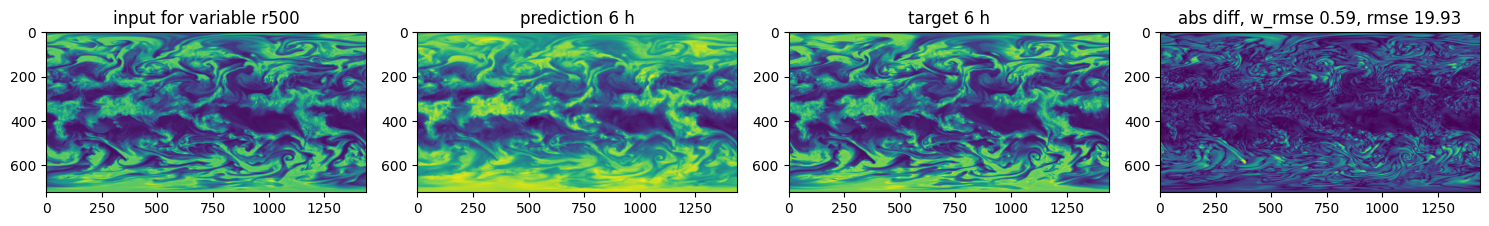

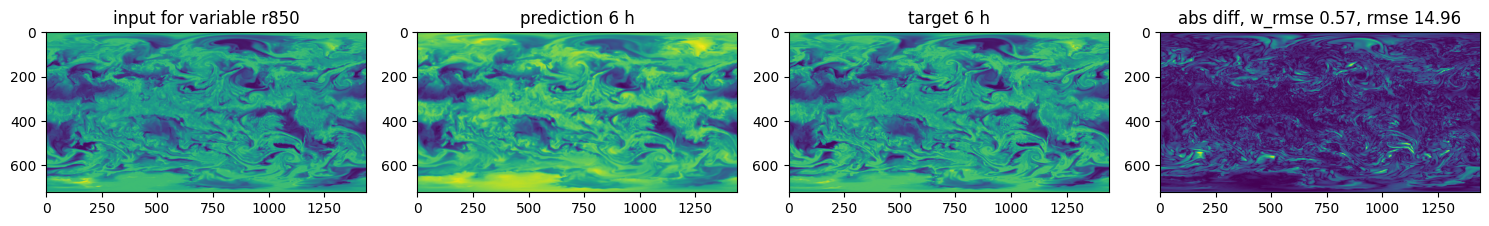

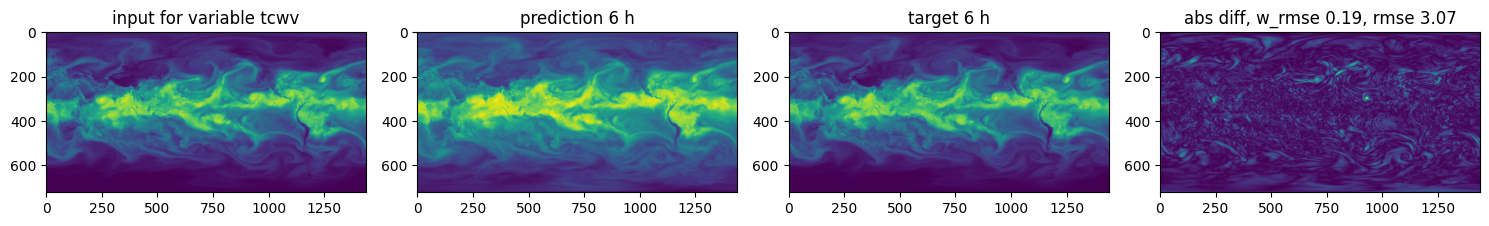

In [77]:
# plot image
import matplotlib.pyplot as plt


def plot_image(inputs, variable = "t2m", log=False):
    idx = VARIABLES.index(variable)
    # x has shape [BATCH_SIZE,  HEIGHT * WIDTH, N_VAR] -> [BATCH_SIZE, HEIGHT, WIDTH, N_VAR]

    for key, value in inputs.items():
        image = value
        image = image.reshape(BATCH_SIZE, HEIGHT, WIDTH, N_VAR)
        image = image[:, :, :, idx]
        image = image.detach().numpy()
        image = image * STDS[idx] + MEANS[idx]
        image = image[0]
        inputs[key] = image



    fig, axs = plt.subplots(1, len(inputs), figsize=(15, 5))
    for i, (key, value) in enumerate(inputs.items()):
        axs[i].imshow(value)
        axs[i].set_title(key)

    plt.tight_layout()
    plt.show()
    


for i , var in enumerate(VARIABLES):
    difference = torch.abs(y_hat - target)
    num = rmse[0][i].item()
    num = round(num, 2)
    num_scaled = rmse_scaled[0][i].item()
    num_scaled = round(num_scaled, 2)

    inputs = {f"input for variable {var}": x, "prediction 6 h": y_hat, "target 6 h": target, f"abs diff, w_rmse {num}, rmse {num_scaled}": difference}
    plot_image(inputs, var)

